# Training adverserial examples for the MNIST - Dataset

Resources: 
- [Normalized Gradients](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_9_Normalized.html#Normalizing-out-the-full-gradient-magnitude)
- [Adverserial Training](https://adversarial-ml-tutorial.org/introduction/)


In [1]:
# part a)
import torch

def pgd(model:torch.nn.Module, X:torch.Tensor, y:torch.Tensor, epsilon: float, alpha: float, num_iter: int) -> torch.Tensor:
    delta = torch.zeros_like(X, requires_grad=True) 
    for _ in range(num_iter):
        loss = torch.nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()


def targeted_pgd(model:torch.nn.Module, X:torch.Tensor, y:torch.Tensor, epsilon: float, alpha: float, num_iter: int, y_targ: int) -> torch.Tensor:
    delta = torch.zeros_like(X, requires_grad=True)
    for _ in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [2]:
# Load the MNIST dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

# use 20% of training data for validation
train_set_size = int(len(mnist_train) * 0.8)
valid_set_size = len(mnist_train) - train_set_size

# split the train set into two
seed = torch.Generator().manual_seed(42)
train_set, valid_set = torch.utils.data.random_split(mnist_train, [train_set_size, valid_set_size], generator=seed)

train_loader = DataLoader(train_set, batch_size = 100, shuffle=True)
validation_loader = DataLoader(valid_set, batch_size=100, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)


In [4]:
import pytorch_lightning as pl
from torch import nn

class CNN(pl.LightningModule):

    def __init__(self):
        super(CNN, self).__init__()        
        self.conv1 = torch.nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)    

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        out = self.forward(x)

        loss = nn.functional.cross_entropy(out, y)
        self.log("train_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        out = self.forward(x)
        test_loss = nn.functional.cross_entropy(out, y)
        self.log("test_loss", test_loss)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.forward(x)
        validiation_loss = nn.functional.cross_entropy(out, y)
        self.log("validation_loss", validiation_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [5]:
cnn = CNN()
trainer = pl.Trainer(max_epochs=1)

/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
trainer.fit(model=cnn, train_dataloaders=train_loader, val_dataloaders=validation_loader)

trainer.test(model=cnn, dataloaders=test_loader)


  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Sequential | 416   
1 | conv2 | Sequential | 12.8 K
2 | out   | Linear     | 15.7 K
-------------------------------------
28.9 K    Trainable params
0         Non-trainable params
28.9 K    Total params
0.116     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking functi

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.07839681953191757
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.07839681953191757}]

In [7]:
# Yay, after "training" out ann we can generate some examples

for X,y in test_loader:
    break

print(X.shape, y.shape)

out_untargeted = pgd(cnn, X, y, epsilon=0.1, alpha=1e4, num_iter=40)
out_targeted = targeted_pgd(cnn, X, y, epsilon=0.2, alpha=1e4, num_iter=40, y_targ=0)

torch.Size([100, 1, 28, 28]) torch.Size([100])


In [8]:
import matplotlib.pyplot as plt

def print_images(X, y, yp, M=3, N=4):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

yp = cnn(X)
yp_adv_untargeted = cnn(X + out_untargeted)
yp_adv_targeted = cnn(X + out_targeted)

normal classification
untargeted adverserial attack
targeted adverserial attack


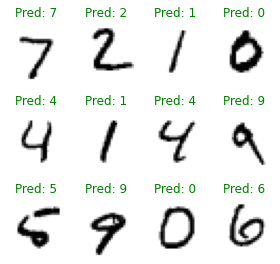

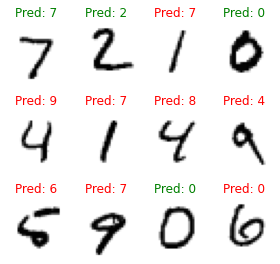

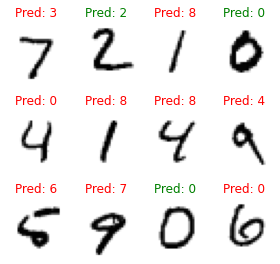

In [9]:
print("normal classification")
print_images(X, y, yp)
print("untargeted adverserial attack")
print_images(X, y, yp_adv_untargeted)
print("targeted adverserial attack")
print_images(X, y, yp_adv_targeted)

In [10]:
# Some more scores etc

yp_label_untargeted = torch.argmax(yp_adv_untargeted, dim=1)
yp_label_targeted = torch.argmax(yp_adv_targeted, dim=1)

print(f"score untargeted: {sum(y == yp_label_untargeted) / len(y)}")
print(f"score targeted: {sum(y == yp_label_targeted) / len(y)}")

score untargeted: 0.3499999940395355
score targeted: 0.2199999988079071


# Task 4

I am doing this in the same notebook, because i dont want to copy alot of code

In [12]:
# now lets modify the test_dataset and evaluate our classifier with that set

print(mnist_test.data.shape)
print(mnist_test.test_labels.shape)

train_loader = DataLoader(train_set, batch_size = 100, shuffle=False)

mod_data_x = []
for i, (X, y) in enumerate(train_loader):
    if i % 10 == 0:
        print(f"still working at episode: {i}")

    o = pgd(cnn, X, y, epsilon=0.1, alpha=1e4, num_iter=40)
    mod_data_x.append(X + o)




torch.Size([10000, 28, 28])
torch.Size([10000])
still working at episode: 0


/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


still working at episode: 10
still working at episode: 20
still working at episode: 30
still working at episode: 40
still working at episode: 50
still working at episode: 60
still working at episode: 70
still working at episode: 80
still working at episode: 90
still working at episode: 100
still working at episode: 110
still working at episode: 120
still working at episode: 130
still working at episode: 140
still working at episode: 150
still working at episode: 160
still working at episode: 170
still working at episode: 180
still working at episode: 190
still working at episode: 200
still working at episode: 210
still working at episode: 220
still working at episode: 230
still working at episode: 240
still working at episode: 250
still working at episode: 260
still working at episode: 270
still working at episode: 280
still working at episode: 290
still working at episode: 300
still working at episode: 310
still working at episode: 320
still working at episode: 330
still working at ep

In [15]:
adv_images = mod_data_x[0]
for a in mod_data_x[1::]:
    adv_images = torch.cat((adv_images, a))

#adv_images = torch.squeeze(t, dim=1)


In [16]:
data_x = []
for X, y in train_loader:
    data_x.append(X)

print(len(data_x))

480


In [17]:
import random
mixed_images = mod_data_x[0]
for i in range(1, len(mod_data_x)):
    r = random.randint(0, 1)
    if r == 1:
        a = mod_data_x[i]
    else:
        a = data_x[i]
    mixed_images = torch.cat((mixed_images, a))

In [18]:
adv_label = mnist_train.train_labels[train_loader.dataset.indices]
adv_dataset = torch.utils.data.TensorDataset(adv_images, adv_label)
mixed_dataset = torch.utils.data.TensorDataset(mixed_images, adv_label)

adv_dataloader = DataLoader(adv_dataset, batch_size=100, shuffle=True)
mixed_dataloader = DataLoader(mixed_dataset, batch_size=100, shuffle=True)

/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [21]:
cnn_adv = CNN()
trainer = pl.Trainer(max_epochs=1)
trainer.fit(model=cnn_adv, train_dataloaders=adv_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Sequential | 416   
1 | conv2 | Sequential | 12.8 K
2 | out   | Linear     | 15.7 K
-------------------------------------
28.9 K    Trainable params
0         Non-trainable params
28.9 K    Total params
0.116     Total estimated model params size (MB)
/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The da

Training: 0it [00:00, ?it/s]

In [22]:
cnn_adv_mixed = CNN()
trainer = pl.Trainer(max_epochs=1)
trainer.fit(model=cnn_adv_mixed, train_dataloaders=mixed_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Sequential | 416   
1 | conv2 | Sequential | 12.8 K
2 | out   | Linear     | 15.7 K
-------------------------------------
28.9 K    Trainable params
0         Non-trainable params
28.9 K    Total params
0.116     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [23]:
trainer.test(model=cnn_adv, dataloaders=test_loader)
trainer.test(model=cnn_adv_mixed, dataloaders=test_loader)

/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6609538793563843
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.0933612808585167
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0933612808585167}]

In [26]:
for X, y in test_loader:
    break

out_untargeted = pgd(cnn_adv, X, y, epsilon=0.1, alpha=1e4, num_iter=40)
out_targeted = targeted_pgd(cnn_adv, X, y, epsilon=0.2, alpha=1e4, num_iter=40, y_targ=0)

yp = cnn_adv(X)
yp_adv_untargeted = cnn_adv(X + out_untargeted)
yp_adv_targeted = cnn_adv(X + out_targeted)


In [27]:
yp_label_untargeted = torch.argmax(yp_adv_untargeted, dim=1)
yp_label_targeted = torch.argmax(yp_adv_targeted, dim=1)

print(f"score untargeted: {sum(y == yp_label_untargeted) / len(y)}")
print(f"score targeted: {sum(y == yp_label_targeted) / len(y)}")

score untargeted: 0.0
score targeted: 0.07000000029802322


In [ ]:
print("normal classification")
print_images(X, y, yp)
print("untargeted adverserial attack")
print_images(X, y, yp_adv_untargeted)
print("targeted adverserial attack")
print_images(X, y, yp_adv_targeted)